In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from copy import deepcopy

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

RANDOM_STATE = 42

# === Load dataset (HR example). Change path if needed ===
fname = "WA_Fn-UseC_-HR-Employee-Attrition.csv"   # change if using another dataset
df = pd.read_csv(fname)

# Basic preprocessing for HR dataset
# Convert Attrition to binary
if 'Attrition' in df.columns:
    df['Attrition'] = (df['Attrition'].astype(str).str.strip().str.lower() == 'yes').astype(int)

# Drop some uninformative ID-like columns if present
drop_cols = [c for c in ['EmployeeCount','Over18','StandardHours','EmployeeNumber'] if c in df.columns]
df = df.drop(columns=drop_cols, errors='ignore')

# One-hot encode categoricals
df = pd.get_dummies(df, drop_first=True)

# X, y and train/test split
target_col = 'Attrition'  # adapt for other datasets
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1176, 44) Test shape: (294, 44)


In [2]:

def candidate_k_values(n_features):
    # choose some sensible candidate k's not exceeding n_features
    base = [5, 8, 10, 12, 15, 20, 25]
    ks = sorted(set([k for k in base if k <= n_features]))
    if not ks:
        ks = [min(10, n_features)]
    if n_features not in ks:
        ks.append(n_features)
    return ks

n_features = X_train.shape[1]
k_values = candidate_k_values(n_features)
print("n_features:", n_features, "k_values:", k_values)

# Define classifiers (keys will be used as dictionary keys everywhere)
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
}

# parameter grids - keys must match pipeline step names: 'kbest__k' and 'classifier__...'
param_grid_dt = {
    'kbest__k': k_values,
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 3, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_knn = {
    'kbest__k': k_values,
    'classifier__n_neighbors': [3, 5, 7, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

param_grid_lr = {
    'kbest__k': k_values,
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],             # keep to l2 to avoid solver conflicts
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__class_weight': [None, 'balanced']
}

param_grids = {
    "DecisionTree": param_grid_dt,
    "KNN": param_grid_knn,
    "LogisticRegression": param_grid_lr
}


n_features: 44 k_values: [5, 8, 10, 12, 15, 20, 25, 44]


In [3]:

from sklearn.base import clone

def run_manual_grid_search(X_train, y_train, classifier_name, estimator, param_grid, cv_splits=5, random_state=RANDOM_STATE):
    keys = list(param_grid.keys())
    values_list = [param_grid[k] for k in keys]

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    best_score = -np.inf
    best_params = None

    # iterate all combos
    total = 1
    for v in values_list:
        total *= len(v)
    print(f"[Manual Grid] {classifier_name}: {total} combos to try (CV={cv_splits})")

    tried = 0
    for combo in product(*values_list):
        params = dict(zip(keys, combo))
        tried += 1
        # build pipeline for this combo
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('kbest', SelectKBest(score_func=f_classif)),
            ('classifier', clone(estimator))
        ])
        # set params like 'kbest__k' etc.
        try:
            pipe.set_params(**params)
        except Exception as e:
            # skip invalid combos
            print("Skipping invalid combo:", params, "error:", e)
            continue

        # 5-fold CV loop
        fold_scores = []
        try:
            for train_idx, val_idx in skf.split(X_train, y_train):
                # support both pandas and numpy
                if hasattr(X_train, 'iloc'):
                    X_tr = X_train.iloc[train_idx]
                    X_val = X_train.iloc[val_idx]
                    y_tr = y_train.iloc[train_idx]
                    y_val = y_train.iloc[val_idx]
                else:
                    X_tr = X_train[train_idx]; X_val = X_train[val_idx]
                    y_tr = y_train[train_idx]; y_val = y_train[val_idx]

                model = clone(pipe).fit(X_tr, y_tr)
                # use predict_proba for ROC AUC
                if hasattr(model, "predict_proba"):
                    y_val_proba = model.predict_proba(X_val)[:, 1]
                else:
                    # fallback: use decision_function if available
                    if hasattr(model, "decision_function"):
                        scores = model.decision_function(X_val)
                        # try to convert to probability-like values via min-max (not ideal)
                        y_val_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
                    else:
                        # cannot compute ROC AUC; skip
                        raise RuntimeError("Cannot compute probabilities or decisions for ROC AUC")
                fold_scores.append(roc_auc_score(y_val, y_val_proba))

            avg_score = np.mean(fold_scores)
        except Exception as e:
            print("Skipping combo during CV due to error:", e)
            continue

        if avg_score > best_score:
            best_score = avg_score
            best_params = deepcopy(params)

        if tried % 20 == 0:
            print(f"  tried {tried}/{total}, current best AUC={best_score:.4f}")

    # Refit pipeline on full training data with best params
    if best_params is None:
        raise RuntimeError(f"No valid parameter combination found for {classifier_name}.")

    best_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('kbest', SelectKBest(score_func=f_classif)),
        ('classifier', clone(estimator))
    ])
    best_pipe.set_params(**best_params)
    best_pipe.fit(X_train, y_train)

    return {
        "classifier_name": classifier_name,
        "best_score_cv": best_score,
        "best_params": best_params,
        "best_estimator": best_pipe
    }


In [4]:

def run_builtin_grid_search(X_train, y_train, classifier_name, estimator, param_grid, cv_splits=5, random_state=RANDOM_STATE, n_jobs=-1):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('kbest', SelectKBest(score_func=f_classif)),
        ('classifier', clone(estimator))
    ])
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=cv,
        n_jobs=n_jobs,
        refit=True,
        return_train_score=False
    )
    grid.fit(X_train, y_train)
    return {
        "classifier_name": classifier_name,
        "best_score_cv": grid.best_score_,
        "best_params": grid.best_params_,
        "best_estimator": grid.best_estimator_,
        "cv_results_": grid.cv_results_
    }


In [5]:

manual_results = {}
for name, est in models.items():
    print("Starting manual grid for:", name)
    res = run_manual_grid_search(X_train, y_train, name, est, param_grids[name], cv_splits=5)
    manual_results[name] = res
    print(f"[Manual Done] {name} best AUC={res['best_score_cv']:.4f} params={res['best_params']}\n")

# Quick check
print("Manual keys:", list(manual_results.keys()))


Starting manual grid for: DecisionTree
[Manual Grid] DecisionTree: 576 combos to try (CV=5)
  tried 20/576, current best AUC=0.6863
  tried 40/576, current best AUC=0.6869
  tried 60/576, current best AUC=0.6994
  tried 80/576, current best AUC=0.6994
  tried 100/576, current best AUC=0.7137
  tried 120/576, current best AUC=0.7137
  tried 140/576, current best AUC=0.7137
  tried 160/576, current best AUC=0.7137
  tried 180/576, current best AUC=0.7137
  tried 200/576, current best AUC=0.7137
  tried 220/576, current best AUC=0.7137
  tried 240/576, current best AUC=0.7137
  tried 260/576, current best AUC=0.7137
  tried 280/576, current best AUC=0.7137
  tried 300/576, current best AUC=0.7137
  tried 320/576, current best AUC=0.7137
  tried 340/576, current best AUC=0.7137
  tried 360/576, current best AUC=0.7137
  tried 380/576, current best AUC=0.7137
  tried 400/576, current best AUC=0.7137
  tried 420/576, current best AUC=0.7137
  tried 440/576, current best AUC=0.7137
  tried 46

In [6]:

builtin_results = {}
for name, est in models.items():
    print("Starting GridSearchCV for:", name)
    res = run_builtin_grid_search(X_train, y_train, name, est, param_grids[name], cv_splits=5, n_jobs=-1)
    builtin_results[name] = res
    print(f"[GridSearchCV Done] {name} best AUC={res['best_score_cv']:.4f} params={res['best_params']}\n")

print("Builtin keys:", list(builtin_results.keys()))


Starting GridSearchCV for: DecisionTree
[GridSearchCV Done] DecisionTree best AUC=0.7137 params={'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'kbest__k': 8}

Starting GridSearchCV for: KNN
[GridSearchCV Done] KNN best AUC=0.7500 params={'classifier__n_neighbors': 11, 'classifier__p': 1, 'classifier__weights': 'distance', 'kbest__k': 20}

Starting GridSearchCV for: LogisticRegression
[GridSearchCV Done] LogisticRegression best AUC=0.8398 params={'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'kbest__k': 44}

Builtin keys: ['DecisionTree', 'KNN', 'LogisticRegression']


In [7]:

def evaluate_and_plot(model, X_test, y_test, title_prefix=""):
    # ensure model is fitted
    # model is expected to be a fitted pipeline or estimator
    if hasattr(model, "predict"):
        pass
    else:
        raise RuntimeError("Provided model is not an estimator")

    y_pred = model.predict(X_test)
    # handle probabilities
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        if hasattr(model, "decision_function"):
            scores = model.decision_function(X_test)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
        else:
            y_proba = np.zeros_like(y_pred, dtype=float)  # fallback (bad for AUC)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)

    # Print metrics
    print(f"\n{title_prefix} Metrics:")
    print(f"  Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC AUC: {auc:.4f}")

    # ROC plot
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure()
    disp.plot()
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC_AUC": auc}



[Manual] DecisionTree Metrics:
  Accuracy: 0.8197  Precision: 0.4318  Recall: 0.4043  F1: 0.4176  ROC AUC: 0.7661


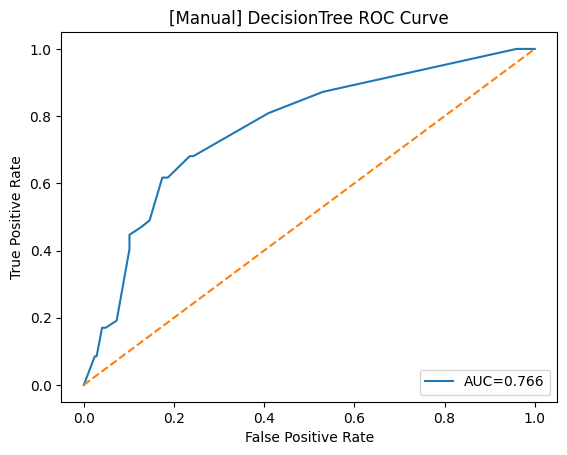

<Figure size 640x480 with 0 Axes>

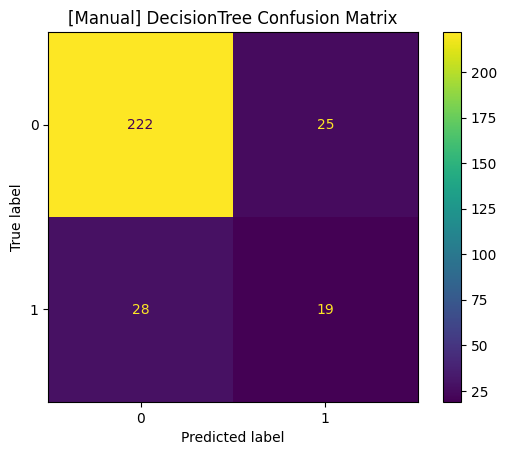


[GridSearchCV] DecisionTree Metrics:
  Accuracy: 0.8197  Precision: 0.4318  Recall: 0.4043  F1: 0.4176  ROC AUC: 0.7661


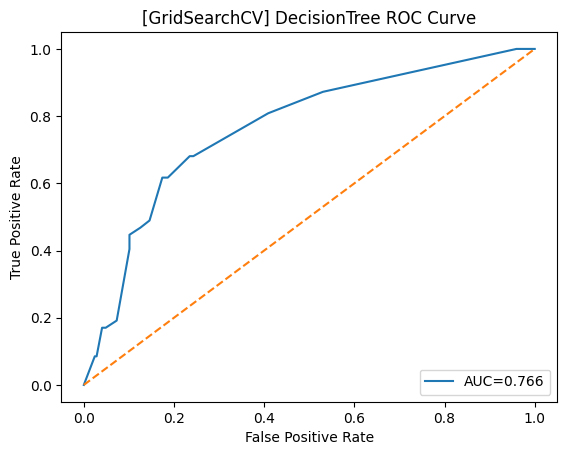

<Figure size 640x480 with 0 Axes>

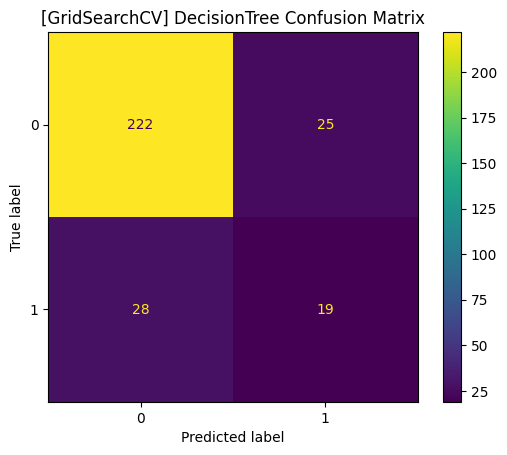


[Manual] KNN Metrics:
  Accuracy: 0.8571  Precision: 0.7778  Recall: 0.1489  F1: 0.2500  ROC AUC: 0.7886


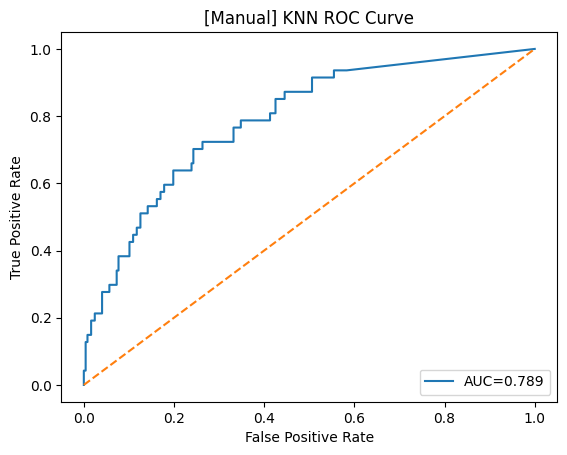

<Figure size 640x480 with 0 Axes>

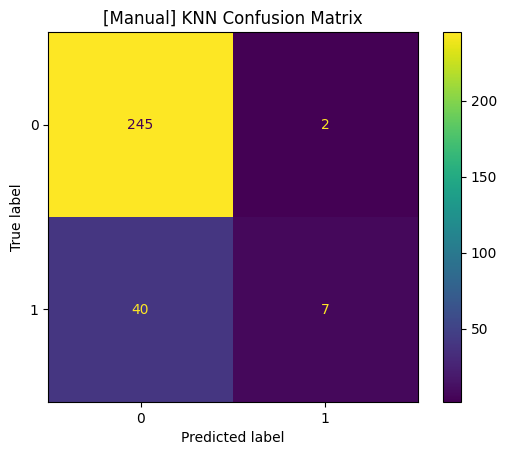


[GridSearchCV] KNN Metrics:
  Accuracy: 0.8571  Precision: 0.7778  Recall: 0.1489  F1: 0.2500  ROC AUC: 0.7886


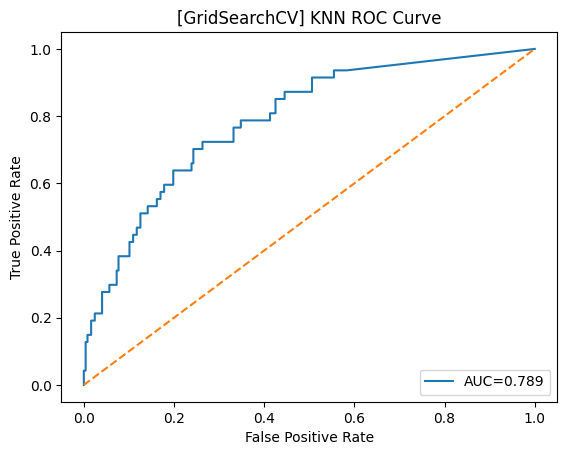

<Figure size 640x480 with 0 Axes>

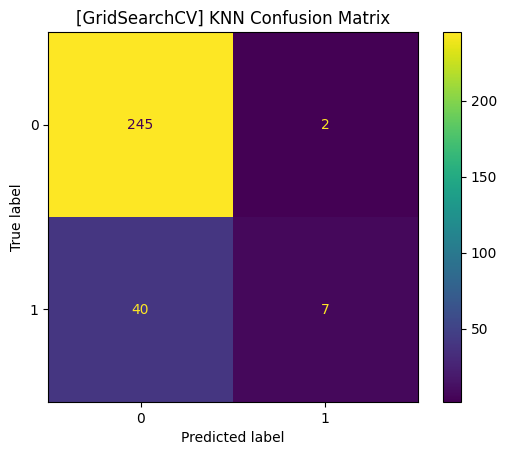


[Manual] LogisticRegression Metrics:
  Accuracy: 0.8639  Precision: 0.6400  Recall: 0.3404  F1: 0.4444  ROC AUC: 0.8086


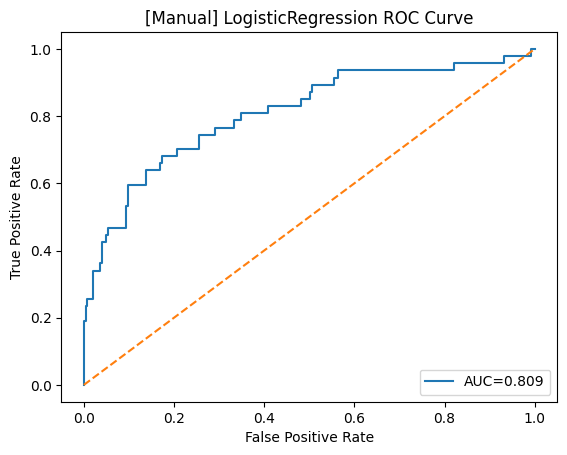

<Figure size 640x480 with 0 Axes>

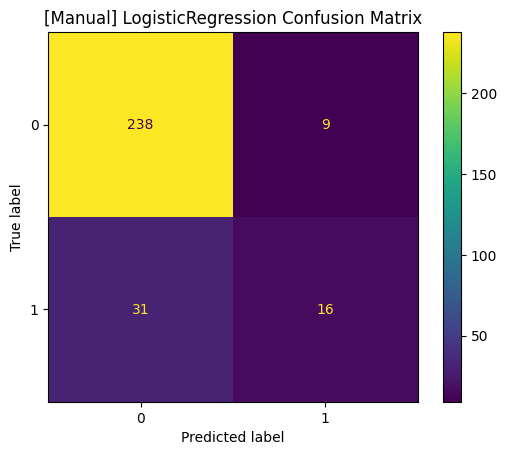


[GridSearchCV] LogisticRegression Metrics:
  Accuracy: 0.8639  Precision: 0.6400  Recall: 0.3404  F1: 0.4444  ROC AUC: 0.8086


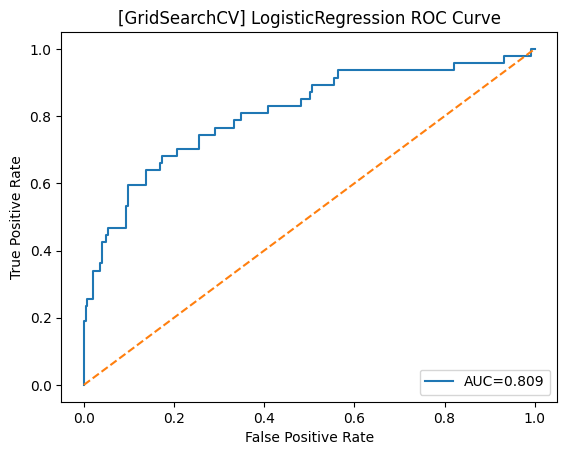

<Figure size 640x480 with 0 Axes>

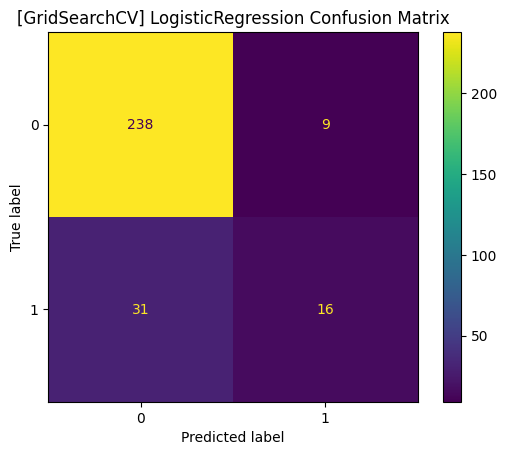

,Dataset,Classifier,Implementation,Accuracy,Precision,Recall,F1,ROC_AUC
0,WA_Fn-UseC_-HR-Employee-Attrition.csv,DecisionTree,Manual,0.819728,0.431818,0.404255,0.417582,0.766087
1,WA_Fn-UseC_-HR-Employee-Attrition.csv,DecisionTree,GridSearchCV,0.819728,0.431818,0.404255,0.417582,0.766087
2,WA_Fn-UseC_-HR-Employee-Attrition.csv,KNN,Manual,0.857143,0.777778,0.148936,0.250000,0.788569
3,WA_Fn-UseC_-HR-Employee-Attrition.csv,KNN,GridSearchCV,0.857143,0.777778,0.148936,0.250000,0.788569
4,WA_Fn-UseC_-HR-Employee-Attrition.csv,LogisticRegression,Manual,0.863946,0.640000,0.340426,0.444444,0.808597
5,WA_Fn-UseC_-HR-Employee-Attrition.csv,LogisticRegression,GridSearchCV,0.863946,0.640000,0.340426,0.444444,0.808597


Saved summary to grid_search_summary_results.csv


In [8]:

rows = []
for name in models.keys():
    # check presence
    if name not in manual_results:
        print(f"Warning: {name} not found in manual_results - skipping manual evaluation")
    else:
        m_best_pipe = manual_results[name]['best_estimator']
        m_metrics = evaluate_and_plot(m_best_pipe, X_test, y_test, title_prefix=f"[Manual] {name}")
        rows.append({
            "Dataset": fname,
            "Classifier": name,
            "Implementation": "Manual",
            **m_metrics
        })

    if name not in builtin_results:
        print(f"Warning: {name} not found in builtin_results - skipping GridSearch evaluation")
    else:
        b_best_pipe = builtin_results[name]['best_estimator']
        b_metrics = evaluate_and_plot(b_best_pipe, X_test, y_test, title_prefix=f"[GridSearchCV] {name}")
        rows.append({
            "Dataset": fname,
            "Classifier": name,
            "Implementation": "GridSearchCV",
            **b_metrics
        })

summary_df = pd.DataFrame(rows)
display(summary_df)
# Optionally save
summary_df.to_csv("grid_search_summary_results.csv", index=False)
print("Saved summary to grid_search_summary_results.csv")


In [9]:
# === Parameter grids for Decision Tree, k-NN, and Logistic Regression ===
from sklearn.model_selection import ParameterGrid

param_grid_dt = {
    'select__k': [5, 8, 12, 15],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_knn = {
    'select__k': [5, 8, 12, 15],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}

param_grid_lr = {
    'select__k': [5, 8, 12, 15],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__penalty': ['l2']
}

print('Parameter grids defined: param_grid_dt, param_grid_knn, param_grid_lr')


Parameter grids defined: param_grid_dt, param_grid_knn, param_grid_lr


In [10]:
# === Helper functions: manual grid search, built-in GridSearchCV, and evaluation ===
from itertools import product
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import clone

def run_manual_grid_search(X, y, classifier, param_grid, scoring='roc_auc', cv_splits=5, random_state=42, verbose=True):
    # Manual grid search over param_grid (params use pipeline names like 'select__k' and 'classifier__C')
    from sklearn.model_selection import ParameterGrid
    grid = list(ParameterGrid(param_grid))
    if verbose: print(f"Total combinations: {len(grid)}")
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    best_score = -np.inf
    best_params = None
    results = []
    for idx, params in enumerate(grid):
        fold_scores = []
        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            # Build pipeline for this fold
            pipe = Pipeline([('scaler', StandardScaler()),
                             ('select', SelectKBest(f_classif, k=params['select__k'])),
                             ('classifier', clone(classifier))])
            # Set classifier-specific params
            clf_params = {k.split('classifier__')[-1]: v for k, v in params.items() if k.startswith('classifier__')}
            if clf_params:
                pipe.named_steps['classifier'].set_params(**clf_params)
            pipe.fit(X_train, y_train)
            # predict_proba or decision_function for roc_auc
            if hasattr(pipe.named_steps['classifier'], 'predict_proba'):
                y_proba = pipe.predict_proba(X_val)[:,1]
            else:
                y_proba = pipe.decision_function(X_val)
            fold_scores.append(roc_auc_score(y_val, y_proba))
        mean_score = np.mean(fold_scores)
        results.append({'params': params, 'mean_test_score': mean_score})
        if verbose and idx % 10 == 0:
            print(f"Checked {idx+1}/{len(grid)} combos. Current mean score: {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_params = params.copy()
    # Refit on full training data with best params
    best_pipe = Pipeline([('scaler', StandardScaler()),
                          ('select', SelectKBest(f_classif, k=best_params['select__k'])),
                          ('classifier', clone(classifier))])
    clf_params = {k.split('classifier__')[-1]: v for k, v in best_params.items() if k.startswith('classifier__')}
    if clf_params:
        best_pipe.named_steps['classifier'].set_params(**clf_params)
    best_pipe.fit(X, y)
    return best_pipe, best_params, best_score, results

def run_builtin_grid_search(X, y, classifier, param_grid, scoring='roc_auc', cv_splits=5, random_state=42, n_jobs=-1, verbose=1):
    # Use GridSearchCV over a pipeline with given classifier and param_grid.
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('select', SelectKBest(f_classif)),
                     ('classifier', classifier)])
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=verbose, refit=True)
    gs.fit(X, y)
    return gs.best_estimator_, gs.best_params_, gs.best_score_, gs

def evaluate_model(pipe, X_test, y_test, pos_label=1, plot=True):
    # Evaluate fitted pipeline on test set. Computes metrics and optionally plots ROC curve and confusion matrix.
    y_pred = pipe.predict(X_test)
    if hasattr(pipe.named_steps['classifier'], 'predict_proba'):
        y_proba = pipe.predict_proba(X_test)[:,1]
    else:
        y_proba = pipe.decision_function(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    if plot:
        # ROC plot
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],'--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure()
        plt.imshow(cm, interpolation='nearest')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.colorbar()
        plt.xticks([0,1])
        plt.yticks([0,1])
        plt.show()
    return metrics


In [17]:
# === Run full pipeline for HR Attrition dataset ===
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display



hr_path = '/content/WA_Fn-UseC_-HR-Employee-Attrition.csv'
df = pd.read_csv(hr_path)
print('HR dataset loaded, shape:', df.shape)
if 'Attrition' not in df.columns:
    raise ValueError("Expected column 'Attrition' in HR dataset.")
    y = (df['Attrition'].map({'Yes':1, 'No':0})).values
    X = df.drop(columns=['Attrition']).copy()
    X = pd.get_dummies(X, drop_first=True)
    print('After get_dummies, feature shape:', X.shape)
    X = X.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print('Train/test split:', X_train.shape, X_test.shape)
    classifiers = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'kNN': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
    }
    param_grids = {
        'DecisionTree': param_grid_dt,
        'kNN': param_grid_knn,
        'LogisticRegression': param_grid_lr
    }
    results = []
    for name, clf in classifiers.items():
        print('\n====', name, ' (Manual Grid Search) ===')
        best_pipe_manual, best_params_manual, best_score_manual, all_res = run_manual_grid_search(X_train, y_train, clf, param_grids[name], verbose=False)
        metrics_manual = evaluate_model(best_pipe_manual, X_test, y_test, plot=True)
        print('Manual best params:', best_params_manual)
        print('Manual ROC AUC (cv mean):', best_score_manual)
        print('Test metrics:', metrics_manual)

        print('\n====', name, ' (GridSearchCV) ===')
        best_pipe_gs, best_params_gs, best_score_gs, gs_obj = run_builtin_grid_search(X_train, y_train, clf, param_grids[name], verbose=0)
        metrics_gs = evaluate_model(best_pipe_gs, X_test, y_test, plot=True)
        print('GridSearchCV best params:', best_params_gs)
        print('GridSearchCV ROC AUC (cv mean):', best_score_gs)
        print('Test metrics:', metrics_gs)

        results.append({
            'dataset': 'HR Attrition',
            'model': name,
            'manual_params': best_params_manual,
            'manual_cv_roc_auc': best_score_manual,
            'manual_test_metrics': metrics_manual,
            'gs_params': best_params_gs,
            'gs_cv_roc_auc': best_score_gs,
            'gs_test_metrics': metrics_gs
        })
    df_results = pd.DataFrame([{
        'dataset': r['dataset'],
        'model': r['model'],
        'manual_cv_roc_auc': r['manual_cv_roc_auc'],
        'gs_cv_roc_auc': r['gs_cv_roc_auc'],
        'manual_test_roc_auc': r['manual_test_metrics']['roc_auc'],
        'gs_test_roc_auc': r['gs_test_metrics']['roc_auc']
    } for r in results])
    display(df_results)
    df_results.to_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv', index=False)
    print('Saved summary to /mnt/data/hr_attrition_results_summary.csv')


HR dataset loaded, shape: (1470, 35)
